1.

Epoch 0 Loss: 0.6420609354972839
Epoch 10 Loss: 0.3126053214073181
Epoch 20 Loss: 0.0683862566947937
Epoch 30 Loss: 0.035541415214538574
Epoch 40 Loss: 0.03249521553516388
Epoch 50 Loss: 0.028538450598716736
Epoch 60 Loss: 0.02706156298518181
Epoch 70 Loss: 0.027665939182043076
Epoch 80 Loss: 0.029055092483758926
Epoch 90 Loss: 0.03085295483469963
Epoch 100 Loss: 0.024022774770855904
Epoch 110 Loss: 0.013650013133883476
Epoch 120 Loss: 0.012069148011505604
Epoch 130 Loss: 0.022197702899575233
Epoch 140 Loss: 0.018754269927740097
Epoch 150 Loss: 0.009707219898700714
Epoch 160 Loss: 0.005230179987847805
Epoch 170 Loss: 0.0025750561617314816
Epoch 180 Loss: 0.0011524508008733392
Epoch 190 Loss: 0.0006164807127788663


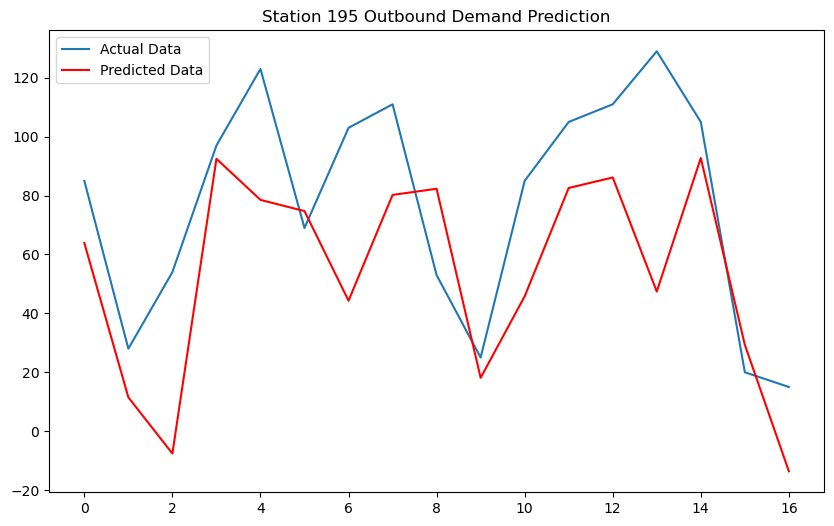

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 读取并准备数据
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_date'] = df['start_time'].dt.date

# 选择特定的站点数据（如站点 ID 195）
station_id = 195
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# 2. 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
outbound_series_scaled = scaler.fit_transform(outbound_series.values.reshape(-1, 1))

# 3. 准备数据集
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 7  # 每7天的数据作为一个输入序列
X, y = create_sequences(outbound_series_scaled, seq_length)

# 将数据划分为训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 4. 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 5. 模型训练
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f'Epoch {i} Loss: {single_loss.item()}')

# 6. 预测并还原数据
model.eval()
with torch.no_grad():
    predictions = []
    for seq in X_test:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())

# 还原预测数据和实际值
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# 7. 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Data')
plt.plot(predictions, label='Predicted Data', color='red')
plt.legend()
plt.title(f'Station {station_id} Outbound Demand Prediction')
plt.show()


预测 Outbound Demand:
Epoch 0 Loss: 0.7081361413002014
Epoch 10 Loss: 0.1271163672208786
Epoch 20 Loss: 0.030874870717525482
Epoch 30 Loss: 0.029398716986179352
Epoch 40 Loss: 0.03223272040486336
Epoch 50 Loss: 0.018640762194991112
Epoch 60 Loss: 0.008286873809993267
Epoch 70 Loss: 0.006356255616992712
Epoch 80 Loss: 0.0040884362533688545
Epoch 90 Loss: 0.0013973030727356672
Epoch 100 Loss: 0.009451265446841717
Epoch 110 Loss: 0.04937862977385521
Epoch 120 Loss: 0.008934183046221733
Epoch 130 Loss: 0.004936507903039455
Epoch 140 Loss: 0.00885644182562828
Epoch 150 Loss: 0.003185957670211792
Epoch 160 Loss: 0.007952379994094372
Epoch 170 Loss: 0.0006438971031457186
Epoch 180 Loss: 0.002710129600018263
Epoch 190 Loss: 0.0048841070383787155


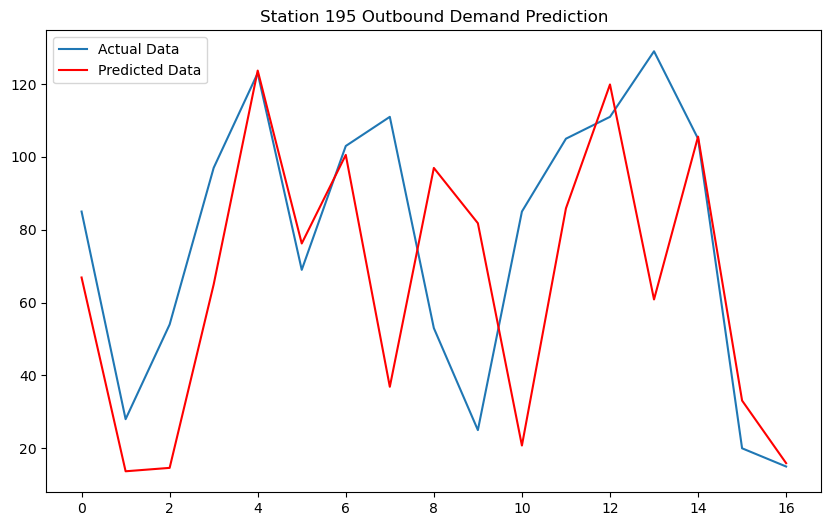

预测 Inbound Demand:
Epoch 0 Loss: 0.3930073082447052
Epoch 10 Loss: 0.14431728422641754
Epoch 20 Loss: 0.025324009358882904
Epoch 30 Loss: 0.009937143884599209
Epoch 40 Loss: 0.004743457771837711
Epoch 50 Loss: 0.0015494455583393574
Epoch 60 Loss: 0.00126420718152076
Epoch 70 Loss: 0.0018081850139424205
Epoch 80 Loss: 6.187528924783692e-05
Epoch 90 Loss: 0.0006278287619352341
Epoch 100 Loss: 0.0002090501511702314
Epoch 110 Loss: 0.0003348375321365893
Epoch 120 Loss: 0.00249999831430614
Epoch 130 Loss: 0.0016229309840127826
Epoch 140 Loss: 0.0001200441547553055
Epoch 150 Loss: 1.941524487847346e-07
Epoch 160 Loss: 0.0002156309928977862
Epoch 170 Loss: 0.0002680910110939294
Epoch 180 Loss: 0.0016157018253579736
Epoch 190 Loss: 0.0007178155356086791


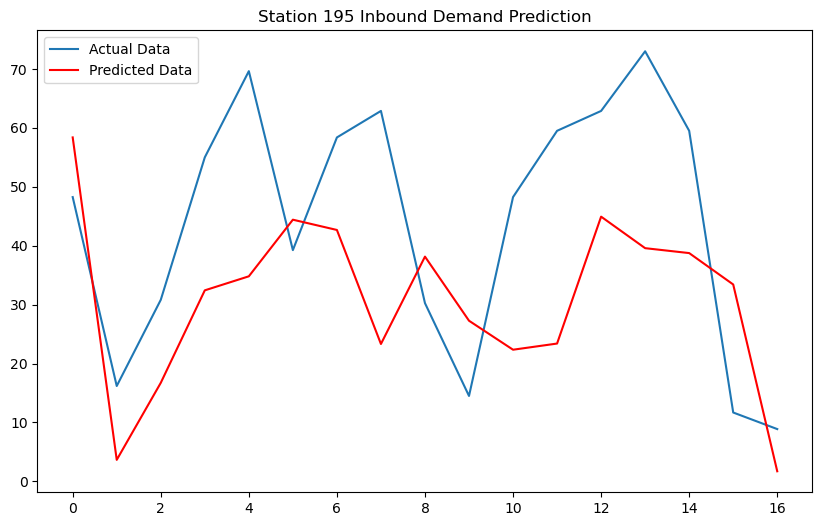

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 读取并准备数据
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

# 选择特定的站点数据（如站点 ID 195）
station_id = 195
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()

outbound_series = outbound_data.asfreq('D', fill_value=0)
inbound_series = inbound_data.asfreq('D', fill_value=0)

# 2. 归一化数据
scaler_out = MinMaxScaler(feature_range=(-1, 1))
outbound_series_scaled = scaler_out.fit_transform(outbound_series.values.reshape(-1, 1))

scaler_in = MinMaxScaler(feature_range=(-1, 1))
inbound_series_scaled = scaler_in.fit_transform(inbound_series.values.reshape(-1, 1))

# 3. 准备数据集
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 7  # 每7天的数据作为一个输入序列
X_out, y_out = create_sequences(outbound_series_scaled, seq_length)
X_in, y_in = create_sequences(inbound_series_scaled, seq_length)

# 将数据划分为训练集和测试集
train_size_out = int(len(X_out) * 0.8)
X_train_out, X_test_out = X_out[:train_size_out], X_out[train_size_out:]
y_train_out, y_test_out = y_out[:train_size_out], y_out[train_size_out:]

train_size_in = int(len(X_in) * 0.8)
X_train_in, X_test_in = X_in[:train_size_in], X_in[train_size_in:]
y_train_in, y_test_in = y_in[:train_size_in], y_in[train_size_in:]

# 转换为 PyTorch 张量
X_train_out = torch.tensor(X_train_out, dtype=torch.float32)
y_train_out = torch.tensor(y_train_out, dtype=torch.float32)
X_test_out = torch.tensor(X_test_out, dtype=torch.float32)
y_test_out = torch.tensor(y_test_out, dtype=torch.float32)

X_train_in = torch.tensor(X_train_in, dtype=torch.float32)
y_train_in = torch.tensor(y_train_in, dtype=torch.float32)
X_test_in = torch.tensor(X_test_in, dtype=torch.float32)
y_test_in = torch.tensor(y_test_in, dtype=torch.float32)

# 4. 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 5. 训练和预测函数
def train_and_predict(model, X_train, y_train, X_test, scaler, title):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    
    epochs = 200
    for i in range(epochs):
        for seq, labels in zip(X_train, y_train):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {single_loss.item()}')

    # 预测并还原数据
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in X_test:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

    # 可视化预测结果
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Data')
    plt.plot(predictions, label='Predicted Data', color='red')
    plt.legend()
    plt.title(title)
    plt.show()

# 6. 分别创建两个模型并进行预测
model_out = LSTMModel()
model_in = LSTMModel()

print('预测 Outbound Demand:')
train_and_predict(model_out, X_train_out, y_train_out, X_test_out, scaler_out, f'Station {station_id} Outbound Demand Prediction')

print('预测 Inbound Demand:')
train_and_predict(model_in, X_train_in, y_train_in, X_test_in, scaler_in, f'Station {station_id} Inbound Demand Prediction')


24h

离站预测:
Epoch 0 Loss: 0.004894459620118141
Epoch 10 Loss: 0.000886413617990911
Epoch 20 Loss: 0.000654970237519592
Epoch 30 Loss: 0.0007495789905078709
Epoch 40 Loss: 0.0007553112809546292
Epoch 50 Loss: 0.00037134220474399626
Epoch 60 Loss: 0.0014336847234517336
Epoch 70 Loss: 0.0019358977442607284
Epoch 80 Loss: 0.0014362586662173271
Epoch 90 Loss: 0.0025535838212817907


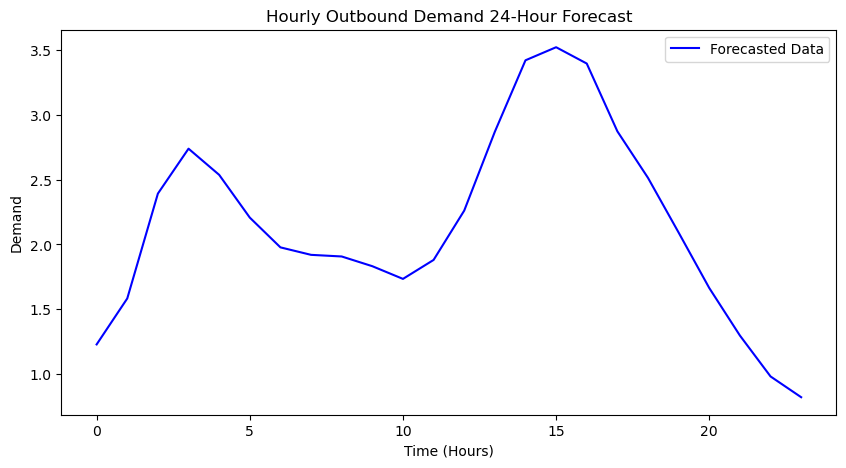

到站预测:
Epoch 0 Loss: 0.0021996020805090666
Epoch 10 Loss: 0.00038065758417360485
Epoch 20 Loss: 0.00035175521043129265
Epoch 30 Loss: 0.0003836918331217021
Epoch 40 Loss: 4.539029760053381e-05
Epoch 50 Loss: 1.1165993782924488e-05
Epoch 60 Loss: 9.035566108650528e-06
Epoch 70 Loss: 6.4337086769228335e-06
Epoch 80 Loss: 2.8040585675626062e-05
Epoch 90 Loss: 2.5164732505800202e-05


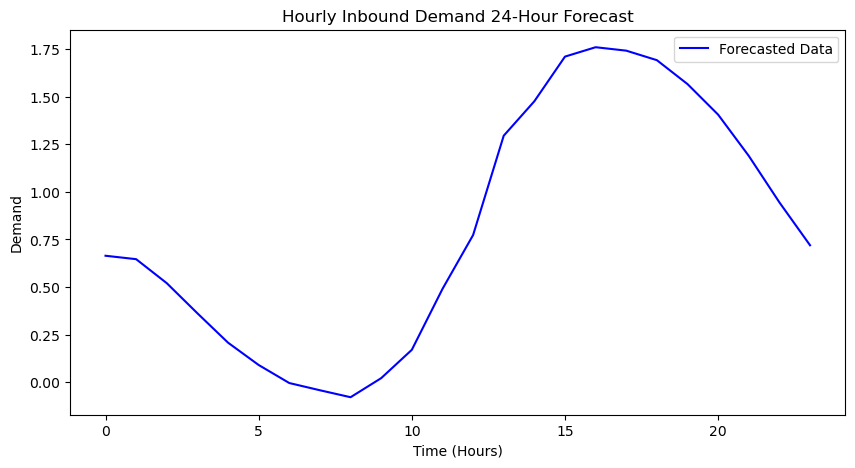

In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 读取数据
files = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']

df_all = pd.DataFrame()

for file in files:
    # 读取数据
    df = pd.read_csv(file)
    
    # 将时间转换为小时级别的时间戳
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['start_hour'] = df['start_time'].dt.floor('H')
    df['end_hour'] = df['end_time'].dt.floor('H')
    
    # 将当前季度的数据追加到总数据中
    df_all = pd.concat([df_all, df], ignore_index=True)

# 3. 选择要分析的站点ID
station_id = 195  # 示例站点ID

# 4. 计算该站点的每小时离站和到站数量
outbound_data = df[df['from_station_id'] == station_id].groupby('start_hour').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_hour').size()

# 填充缺失的小时数据为0，并设置为每小时频率
outbound_series = outbound_data.asfreq('H', fill_value=0)
inbound_series = inbound_data.asfreq('H', fill_value=0)

# 5. 归一化数据
scaler_out = MinMaxScaler(feature_range=(-1, 1))
outbound_series_scaled = scaler_out.fit_transform(outbound_series.values.reshape(-1, 1))

scaler_in = MinMaxScaler(feature_range=(-1, 1))
inbound_series_scaled = scaler_in.fit_transform(inbound_series.values.reshape(-1, 1))

# 6. 创建序列函数
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 24  # 使用前24小时的数据来预测未来1小时
X_out, y_out = create_sequences(outbound_series_scaled, seq_length)
X_in, y_in = create_sequences(inbound_series_scaled, seq_length)

# 转换为 PyTorch 张量
X_out = torch.tensor(X_out, dtype=torch.float32)
y_out = torch.tensor(y_out, dtype=torch.float32)
X_in = torch.tensor(X_in, dtype=torch.float32)
y_in = torch.tensor(y_in, dtype=torch.float32)

# 7. 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 8. 训练和预测函数
def train_and_predict(model, X, y, scaler, title):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100

    # 训练模型
    for i in range(epochs):
        for seq, labels in zip(X, y):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {single_loss.item()}')

    # 预测未来 24 小时
    model.eval()
    with torch.no_grad():
        predictions = []
        seq = X[-1]  # 从训练数据的最后一段序列开始
        for _ in range(24):  # 预测未来24小时
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            predictions.append(y_pred.item())
            seq = torch.cat((seq[1:], y_pred.view(1, -1)))  # 滑动窗口

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # 可视化预测结果
    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Forecasted Data', color='blue')
    plt.title(f'{title} 24-Hour Forecast')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

# 9. 训练并预测离站和到站
print('离站预测:')
model_out = LSTMModel()
train_and_predict(model_out, X_out, y_out, scaler_out, 'Hourly Outbound Demand')
torch.save(model_out.state_dict(), 'model_out.pth')  # 保存离站模型


print('到站预测:')
model_in = LSTMModel()
train_and_predict(model_in, X_in, y_in, scaler_in, 'Hourly Inbound Demand')
torch.save(model_in.state_dict(), 'model_in.pth')  # 保存离站模型



周期性 LSTM

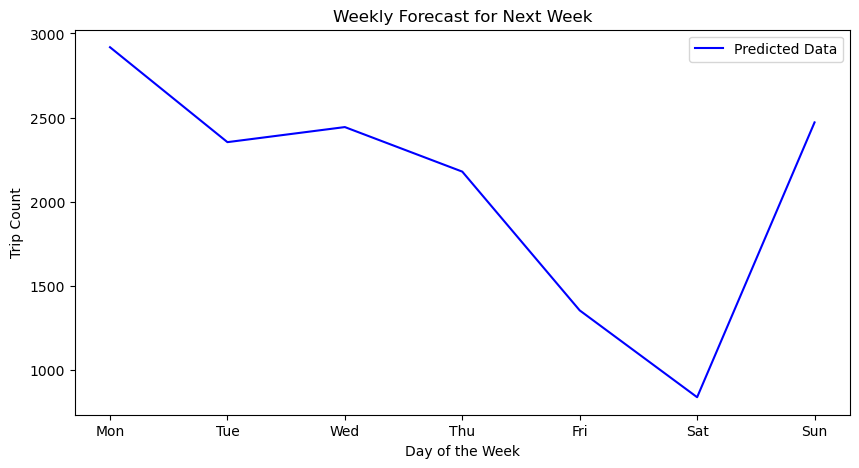

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 读取并合并四个季度的数据
# 假设四个季度数据文件命名为 'Divvy_Trips_2019_Q1.csv', ..., 'Divvy_Trips_2019_Q4.csv'
data_files = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df = pd.concat([pd.read_csv(file) for file in data_files])

# 2. 将时间转换为日期格式并提取星期
df['start_time'] = pd.to_datetime(df['start_time'])
df['date'] = df['start_time'].dt.date
df['weekday'] = df['start_time'].dt.weekday  # 0 = Monday, ..., 6 = Sunday

# 3. 每日出行量的聚合
daily_counts = df.groupby('date').size().reset_index(name='trip_count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# 4. 填充日期缺失值，并按每周重新整理数据
daily_counts.set_index('date', inplace=True)
daily_counts = daily_counts.asfreq('D', fill_value=0)
daily_counts['weekday'] = daily_counts.index.weekday

# 5. 转换为按星期周期的时间序列
# weekly_series = daily_counts.groupby('weekday')['trip_count'].apply(lambda x: x.values).values.reshape(-1, 7)
# weekly_series = np.array([x for x in daily_counts.groupby(daily_counts.index.weekday)['trip_count']]).T
weekly_series = []

# Accumulate daily counts by week
for i in range(0, len(daily_counts), 7):
    week_data = daily_counts['trip_count'].iloc[i:i+7].values
    # If the week has less than 7 days, pad with zeros
    if len(week_data) < 7:
        week_data = np.pad(week_data, (0, 7 - len(week_data)), 'constant')
    weekly_series.append(week_data)

# Convert to NumPy array
weekly_series = np.array(weekly_series)

# 6. 归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
weekly_series_scaled = scaler.fit_transform(weekly_series)

# 7. 创建LSTM输入序列
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 4  # 使用前四周的数据来预测下一周
X, y = create_sequences(weekly_series_scaled, seq_length)

# 转换为 PyTorch 张量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 8. 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=7, hidden_layer_size=50, output_size=7):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 9. 训练模型
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for i in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

# 10. 预测下一周的数据
model.eval()
with torch.no_grad():
    test_seq = X[-1]  # 取最后一段序列作为测试输入
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    y_pred = model(test_seq).numpy()
    y_pred = scaler.inverse_transform(y_pred.reshape(1, -1)).flatten()  # 还原数据

# 11. 可视化预测结果
plt.figure(figsize=(10, 5))
plt.plot(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], y_pred, label='Predicted Data', color='blue')
plt.title('Weekly Forecast for Next Week')
plt.xlabel('Day of the Week')
plt.ylabel('Trip Count')
plt.legend()
plt.show()
